In [111]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Building a Small System BUG Simulation

In [112]:
from copy import deepcopy

from numpy import asarray, sqrt, eye, abs as npabs, kron, pi, ndarray, append
from matplotlib.pyplot import subplots, show

from pytreenet.core import Node
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.operators import TensorProduct, Hamiltonian, pauli_matrices
from pytreenet.ttno import TreeTensorNetworkOperator

from pytreenet.time_evolution.bug import BUG, BUGConfig
from pytreenet.time_evolution.exact_time_evolution import ExactTimeEvolution

In [113]:
time_step_size = 0.01
final_time = 3.2

## Single Qubit

### Preparation

In [114]:
# Generate TTNS
dim = 2
node_id = "Node"
sq_state = asarray([1.0, 0.0], dtype=complex)
sq_node = Node(identifier=node_id)
sq_ttns = TreeTensorNetworkState()
sq_ttns.add_root(sq_node,sq_state)
print(sq_ttns.tensors)
print(sq_ttns.nodes)

{'Node': array([1.+0.j, 0.+0.j])}
{'Node': <pytreenet.core.node.Node object at 0x7f8af6beb6d0>}


In [115]:
# Generate X-Hamiltonian TTNO
term = TensorProduct({node_id: "X"})
sigma_x = pauli_matrices()[0]
identity = eye(dim)
sq_conv_dict = {"I2": identity, "X": sigma_x}
sq_hamiltonian = Hamiltonian(term, conversion_dictionary=sq_conv_dict)
sq_ttno = TreeTensorNetworkOperator.from_hamiltonian(sq_hamiltonian, sq_ttns)
print(sq_ttno.tensors)
print(sq_ttno.nodes)

{'Node': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}
{'Node': <pytreenet.core.node.Node object at 0x7f8af6be9a10>}


In [116]:
# Generate Z-Operator
sigma_z = pauli_matrices()[2]
sq_op_id = "SQ_Operator"
sq_z_op = {sq_op_id: TensorProduct({node_id: sigma_z})}
print(sq_z_op)

{'SQ_Operator': {'Node': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}}


### Simulation

In [117]:
sq_bug = BUG(sq_ttns, sq_ttno, time_step_size, final_time, sq_z_op)

In [118]:
sq_bug.run()

100%|██████████| 321/321 [00:00<00:00, 2951.12it/s]


### Reference Simulation

In [119]:
sq_ref_state = asarray([1.0, 0.0], dtype=complex)
sq_ref_ham = pauli_matrices()[0]
sq_ref_op = {sq_op_id: pauli_matrices()[2]}

In [120]:
sq_exact = ExactTimeEvolution(sq_ref_state, sq_ref_ham, time_step_size, final_time, sq_ref_op)

In [121]:
sq_exact.run()

100%|██████████| 321/321 [00:00<00:00, 154135.27it/s]


### Evaluation & Plotting

In [122]:
times = sq_bug.times()

In [123]:
print("Sanity Check: ", sq_bug.results_real())
sq_results = sq_bug.operator_result(sq_op_id, realise=True)
sq_exact_results = sq_exact.operator_result(sq_op_id, realise=True)
sq_error = npabs(sq_results - sq_exact_results)

Sanity Check:  True


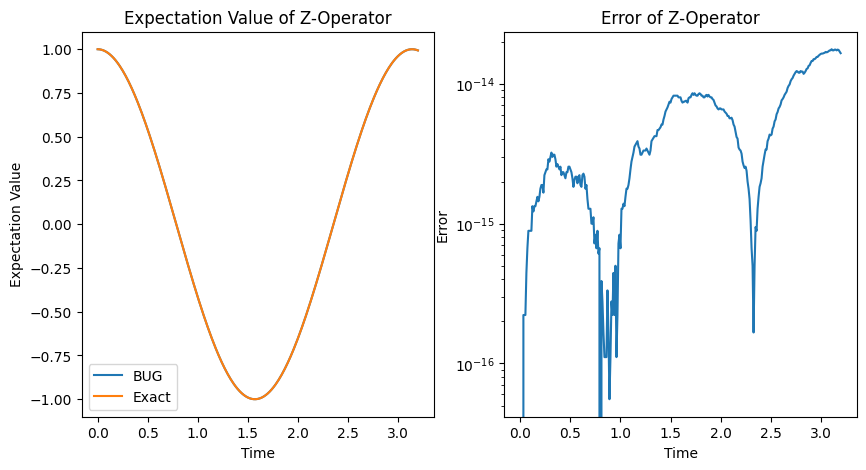

In [124]:
fig, axs = subplots(1, 2, figsize=(10, 5))

axs[0].plot(times, sq_results, label="BUG")
axs[0].plot(times, sq_exact_results, label="Exact")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Expectation Value")
axs[0].set_title("Expectation Value of Z-Operator")
axs[0].legend()

axs[1].semilogy(times, sq_error)
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Error")
axs[1].set_title("Error of Z-Operator")

show()

## Two Qubits

The CNOT-Gate can be won from a Hermitian operator like so
$$
\text{CNOT} = e^{-i \frac{\pi}{4}(I_1-Z_1)(I_2-X_2)}.
$$
To ensure entanglement generation, we will use the initial state $\frac{1}{\sqrt{2}} (\ket{0} + \ket{1}) \otimes \ket{0}$.

### Preparation

In [125]:
# Initial State
dim = 2
init_state_0 = (1/sqrt(2)) * asarray([1.0, 1.0], dtype=complex)
init_state_0 = init_state_0.reshape(1,dim)
init_state_1 = asarray([1.0, 0.0], dtype=complex)
init_state_1 = init_state_1.reshape(1,dim)

qubit0_id = "Qubit0"
node_0 = Node(identifier=qubit0_id)
qubit1_id = "Qubit1"
node_1 = Node(identifier=qubit1_id)

tq_ttns = TreeTensorNetworkState()
tq_ttns.add_root(node_0, init_state_0)
tq_ttns.add_child_to_parent(node_1, init_state_1, 0, qubit0_id, 0)


In [126]:
# Generate CNOT-Hamiltonian TTNO
term = TensorProduct({qubit0_id: "q0_op", qubit1_id: "q1_op"})
q0_op = eye(dim) - pauli_matrices()[2]
q1_op = eye(dim) - pauli_matrices()[0]
tq_conv_dict = {"I2": identity, "q0_op": q0_op, "q1_op": q1_op}
tq_hamiltonian = Hamiltonian(term, conversion_dictionary=tq_conv_dict)
tq_ttno = TreeTensorNetworkOperator.from_hamiltonian(tq_hamiltonian, tq_ttns)

In [127]:
# Operators
tq_ops = {qubit0_id: TensorProduct({qubit0_id: pauli_matrices()[2]}),
          qubit1_id: TensorProduct({qubit1_id: pauli_matrices()[2]})}


### Simulation

In [128]:
config = BUGConfig(record_bond_dim=True)
final_time = 2*3.2
tq_bug = BUG(tq_ttns, tq_ttno, time_step_size, final_time, tq_ops, config=config)

In [129]:
tq_bug.run()

100%|██████████| 641/641 [00:00<00:00, 701.90it/s]


### Exact Simulation

In [130]:
tq_ref_state = kron( (1/sqrt(2)) * asarray([1.0, 1.0], dtype=complex), asarray([1.0, 0.0], dtype=complex) )
tq_ref_ham = kron( eye(dim) - pauli_matrices()[2], eye(dim) - pauli_matrices()[0] )
tq_ref_ops = {qubit1_id: kron(eye(dim), pauli_matrices()[2]), qubit0_id: kron(pauli_matrices()[2], eye(dim))}
tq_exact = ExactTimeEvolution(tq_ref_state, tq_ref_ham, time_step_size, final_time, tq_ref_ops)

In [131]:
tq_exact.run()

100%|██████████| 641/641 [00:00<00:00, 107960.84it/s]


### Results & Plots

In [132]:
times = tq_bug.times()

In [133]:
print("Sanity Check: ", tq_bug.results_real())
tq_results0 = tq_bug.operator_result(qubit0_id, realise=True)
tq_results1 = tq_bug.operator_result(qubit1_id, realise=True)
tq_exact_results0 = tq_exact.operator_result(qubit0_id, realise=True)
tq_exact_results1 = tq_exact.operator_result(qubit1_id, realise=True)
tq_error0 = npabs(tq_results0 - tq_exact_results0)
tq_error1 = npabs(tq_results1 - tq_exact_results1)

Sanity Check:  True


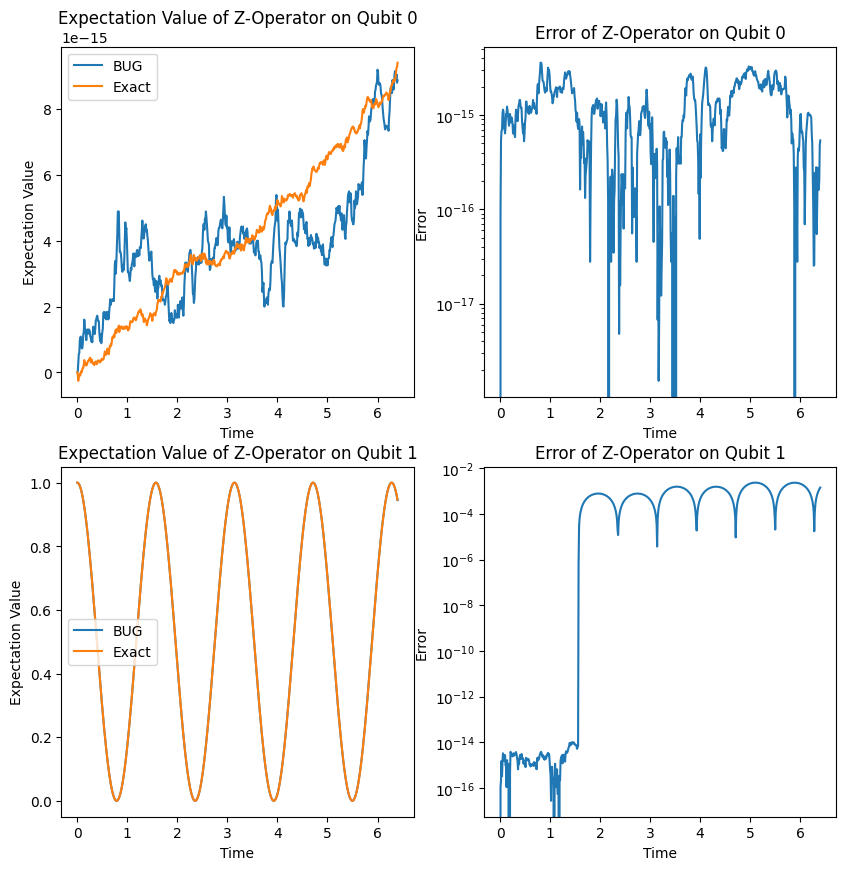

In [134]:
fig, axs = subplots(2,2, figsize=(10, 10))

axs[0,0].plot(times, tq_results0, label="BUG")
axs[0,0].plot(times, tq_exact_results0, label="Exact")
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Expectation Value")
axs[0,0].set_title("Expectation Value of Z-Operator on Qubit 0")
axs[0,0].legend()

axs[1,0].plot(times, tq_results1, label="BUG")
axs[1,0].plot(times, tq_exact_results1, label="Exact")
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Expectation Value")
axs[1,0].set_title("Expectation Value of Z-Operator on Qubit 1")
axs[1,0].legend()

axs[0,1].semilogy(times, tq_error0)
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Error")
axs[0,1].set_title("Error of Z-Operator on Qubit 0")

axs[1,1].semilogy(times, tq_error1)
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Error")
axs[1,1].set_title("Error of Z-Operator on Qubit 1")

show()

In [135]:
tq_bond_dim = tq_bug.operator_result("bond_dim")[(qubit0_id,qubit1_id)]

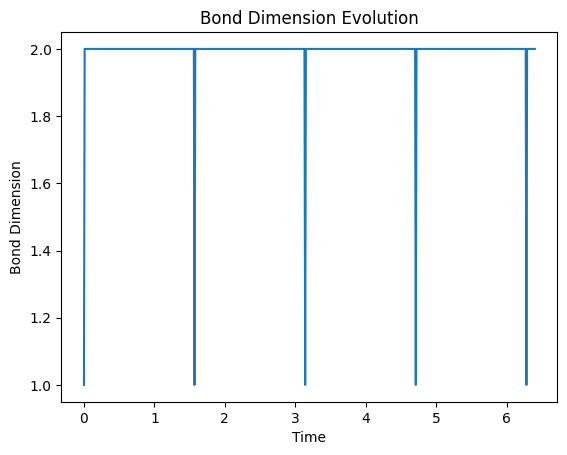

In [136]:
fig, ax = subplots(1,1)

ax.plot(times, tq_bond_dim)
ax.set_xlabel("Time")
ax.set_ylabel("Bond Dimension")
ax.set_title("Bond Dimension Evolution")

show()

## Two Qubits: Tucker Tensor
We repeat the simulation of a CNOT gate, but the two qubits are separated by a root node.'

In [137]:
# Initial State
dim = 2
init_state_0 = (1/sqrt(2)) * asarray([1.0, 1.0], dtype=complex)
init_state_0 = init_state_0.reshape(1,dim)
init_state_1 = asarray([1.0, 0.0], dtype=complex)
init_state_1 = init_state_1.reshape(1,dim)
init_state_root = asarray([1], dtype=complex)
init_state_root = init_state_root.reshape(1,1,1)

root_id = "Root"
node_r = Node(identifier=root_id)
qubit0_id = "Qubit0"
node_0 = Node(identifier=qubit0_id)
qubit1_id = "Qubit1"
node_1 = Node(identifier=qubit1_id)

tt_ttns = TreeTensorNetworkState()
tt_ttns.add_root(node_r,init_state_root)
tt_ttns.add_child_to_parent(node_0,init_state_0,0,
                            root_id,0)
tt_ttns.add_child_to_parent(node_1,init_state_1,0,
                            root_id,1)


In [138]:
# We can reuse most of the code from above
tq_hamiltonian.conversion_dictionary["I1"] = eye(1)
tt_ttno = TreeTensorNetworkOperator.from_hamiltonian(tq_hamiltonian, tt_ttns)


### Simulation

In [139]:
config = BUGConfig(record_bond_dim=True,deep=False)
tt_bug = BUG(tt_ttns, tt_ttno, time_step_size, final_time, tq_ops, config=config)

In [140]:
tt_bug.run()

100%|██████████| 641/641 [00:01<00:00, 379.83it/s]


### Results & Plots
As the exact solution will be the same, we can go directly to the results.

In [141]:
times = tt_bug.times()

In [142]:
print("Sanity Check: ", tt_bug.results_real())
tt_results0 = tt_bug.operator_result(qubit0_id, realise=True)
tt_results1 = tt_bug.operator_result(qubit1_id, realise=True)
tq_exact_results0 = tq_exact.operator_result(qubit0_id, realise=True)
tq_exact_results1 = tq_exact.operator_result(qubit1_id, realise=True)
tt_error0 = npabs(tt_results0 - tq_exact_results0)
tt_error1 = npabs(tt_results1 - tq_exact_results1)

Sanity Check:  True


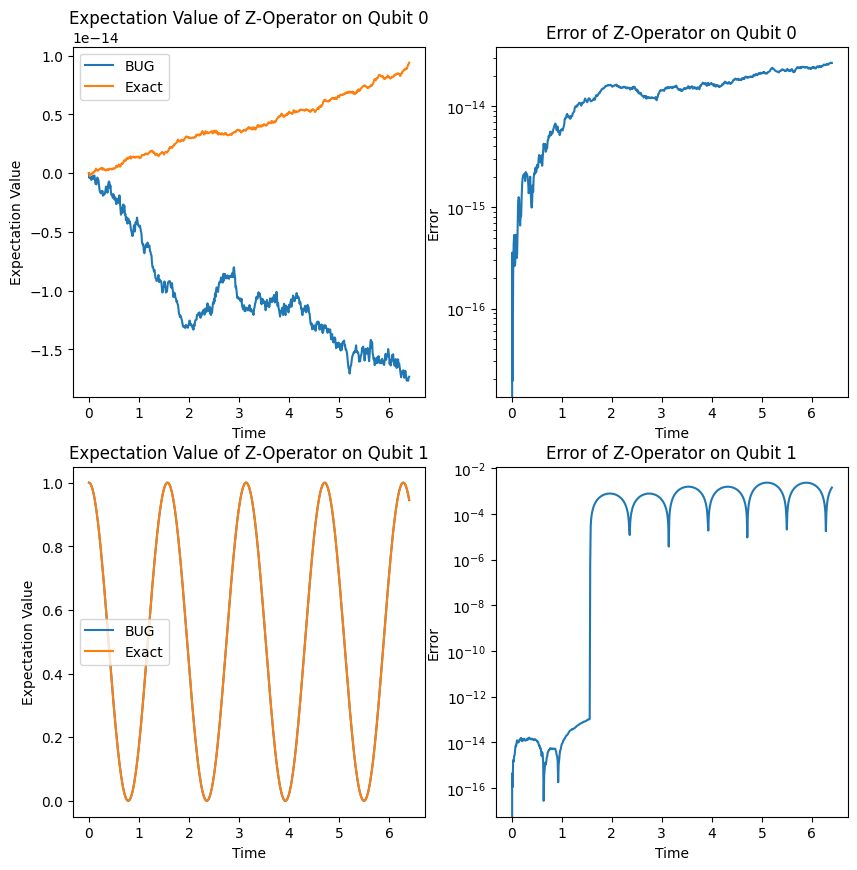

In [143]:
fig, axs = subplots(2,2, figsize=(10, 10))

axs[0,0].plot(times, tt_results0, label="BUG")
axs[0,0].plot(times, tq_exact_results0, label="Exact")
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Expectation Value")
axs[0,0].set_title("Expectation Value of Z-Operator on Qubit 0")
axs[0,0].legend()

axs[1,0].plot(times, tt_results1, label="BUG")
axs[1,0].plot(times, tq_exact_results1, label="Exact")
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Expectation Value")
axs[1,0].set_title("Expectation Value of Z-Operator on Qubit 1")
axs[1,0].legend()

axs[0,1].semilogy(times, tt_error0)
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Error")
axs[0,1].set_title("Error of Z-Operator on Qubit 0")

axs[1,1].semilogy(times, tt_error1)
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Error")
axs[1,1].set_title("Error of Z-Operator on Qubit 1")

show()

## Four Qubits

Four qubits are is the shortest chain for which we can have a bond dimension larger then than the qubit dimension $2$.
One state requiring this is
$$
\ket{\psi} = \frac{1}{2} ( \ket{0000} + \ket{1110} + \ket{0101}+ \ket{1011})
$$
We can obtain this state from the initial state $\ket{0000}$ by applying the following circuit
$$
 \text{C}_1\text{NOT}_2 \cdot \text{C}_2\text{NOT}_1 \cdot (\text{C}_0\text{NOT}_1 \otimes \text{C}_3\text{NOT}_2) \cdot (H_0 \otimes H_3),
$$
where $H$ ist the Hadamard gate and $\text{C}_i\text{NOT}_j$ is the controlled Pauli-$X$ operation, with the controll qubit $i$.
We can obatain it from a TTN-time evolution, by running multiple evolutions each, with a gate evolution and the final state of the evolution before as the initial state.

### Preparation

In [144]:
# Initial State
num_sites = 4
sup_state = (1/sqrt(2)) * asarray([1.0, 1.0], dtype=complex)
ket_0 = asarray([1.0, 0.0], dtype=complex)
ket_1 = asarray([0.0, 1.0], dtype=complex)

qubit_ids = [f"Qubit{i}" for i in range(num_sites)]
fq_ttns = TreeTensorNetworkState()
# Root Q1
q1_node = Node(identifier=qubit_ids[1])
local_tensor = deepcopy(ket_0.reshape(1,1,2))
fq_ttns.add_root(q1_node, local_tensor)
# Q0 to the left
q0_node = Node(identifier=qubit_ids[0])
local_tensor = deepcopy(sup_state.reshape(1,2))
fq_ttns.add_child_to_parent(q0_node, local_tensor, 0, qubit_ids[1], 0)
# Q2 to the right
q2_node = Node(identifier=qubit_ids[2])
local_tensor = deepcopy(ket_0.reshape(1,1,2))
fq_ttns.add_child_to_parent(q2_node, local_tensor, 0, qubit_ids[1], 1)
# Q3 to the right of Q2
q3_node = Node(identifier=qubit_ids[3])
local_tensor = deepcopy(sup_state.reshape(1,2))
fq_ttns.add_child_to_parent(q3_node, local_tensor, 0, qubit_ids[2], 1)

print([(identifier, tensor.shape) for identifier, tensor in fq_ttns.tensors.items()])

[('Qubit1', (1, 1, 2)), ('Qubit0', (1, 2)), ('Qubit2', (1, 1, 2)), ('Qubit3', (1, 2))]


In [145]:
def gen_cnot_hamiltonian(control_id: str,
                         target_id: str
                         ) -> Hamiltonian:
    """
    Generate a CNOT Hamiltonian for a given control and target qubit.

    Args:
        control_id: Identifier of the control qubit.
        target_id: Identifier of the target qubit.

    Returns:
        Hamiltonian: Hamiltonian for the CNOT gate.
    """
    dim = 2
    term = TensorProduct({control_id: "q0_op", target_id: "q1_op"})
    q0_op = eye(dim) - pauli_matrices()[2]
    q1_op = eye(dim) - pauli_matrices()[0]
    conv_dict = {"I2": identity, "q0_op": q0_op, "q1_op": q1_op}
    hamiltonian = Hamiltonian(term, conversion_dictionary=conv_dict)
    return hamiltonian
    

In [146]:
# Hamiltonians
fq_ham_1 = gen_cnot_hamiltonian(qubit_ids[0], qubit_ids[1])
fq_ham_1.add_hamiltonian(gen_cnot_hamiltonian(qubit_ids[3], qubit_ids[2]))
fq_ttno_1 = TreeTensorNetworkOperator.from_hamiltonian(fq_ham_1, fq_ttns)
fq_ham_2 = gen_cnot_hamiltonian(qubit_ids[2], qubit_ids[1])
fq_ttno_2 = TreeTensorNetworkOperator.from_hamiltonian(fq_ham_2, fq_ttns)
fq_ham_3 = gen_cnot_hamiltonian(qubit_ids[1], qubit_ids[2])
fq_ttno_3 = TreeTensorNetworkOperator.from_hamiltonian(fq_ham_3, fq_ttns)

In [147]:
# Z-Operators
fq_ops = {qubit_ids[i]: TensorProduct({qubit_ids[i]: pauli_matrices()[2]}) for i in range(num_sites)}

### Simulation

In [148]:
final_time = pi / 4 # This is how long it takes a CNOT to run
config = BUGConfig(record_bond_dim=True,rel_tol=0.0,total_tol=0.0)
fq_bug1 = BUG(fq_ttns, fq_ttno_1, time_step_size, final_time, fq_ops, config=config)
fq_bug1.run()
fq_bug2 = BUG(fq_bug1.state, fq_ttno_2, time_step_size, final_time, fq_ops, config=config)
fq_bug2.run()
fq_bug3 = BUG(fq_bug2.state, fq_ttno_3, time_step_size, final_time, fq_ops, config=config)
fq_bug3.run()


 31%|███▏      | 25/80 [00:00<00:00, 240.91it/s]

100%|██████████| 80/80 [00:00<00:00, 248.51it/s]


### Exact Simulation

In [149]:
# State
superpos = 1/sqrt(2) * asarray([1.0, 1.0], dtype=complex)
ket_0 = asarray([1.0, 0.0], dtype=complex)
fq_ref_state = kron(kron(superpos, ket_0), kron(ket_0, superpos))

In [150]:
def gen_cnot_ham_matrix(control: bool) -> ndarray:
    """
    Generate the matrix representation of a CNOT gate Hamiltonian.

    Args:
        control: Whether the left qubit is te control qubit (True) or the right qubit (False).

    Returns:
        ndarray: Matrix representation of the CNOT gate Hamiltonian.

    """
    sigma_x, _, sigma_z = pauli_matrices()
    if control:
        return kron(eye(dim) - sigma_z, eye(dim) - sigma_x)
    else:
        return kron(eye(dim) - sigma_x, eye(dim) - sigma_z)

In [151]:
# Hamiltonians
fq_ref_ham_1 = kron(gen_cnot_ham_matrix(True), gen_cnot_ham_matrix(False))
fq_ref_ham_2 = kron(eye(dim), kron(gen_cnot_ham_matrix(False), eye(dim)))
fq_ref_ham_3 = kron(eye(dim), kron(gen_cnot_ham_matrix(True), eye(dim)))

In [152]:
# Operators
fq_ref_ops = {qubit_ids[i]: kron(eye(dim**i), kron(pauli_matrices()[2], eye(dim**(num_sites-i-1)))) for i in range(num_sites)}
print([op.shape for op in fq_ref_ops.values()])

[(16, 16), (16, 16), (16, 16), (16, 16)]


In [153]:
# Simulation
fq_exact1 = ExactTimeEvolution(fq_ref_state, fq_ref_ham_1, time_step_size, final_time, fq_ref_ops)
fq_exact1.run()
fq_exact2 = ExactTimeEvolution(fq_exact1.state, fq_ref_ham_2, time_step_size, final_time, fq_ref_ops)
fq_exact2.run()
fq_exact3 = ExactTimeEvolution(fq_exact2.state, fq_ref_ham_3, time_step_size, final_time, fq_ref_ops)
fq_exact3.run()

100%|██████████| 80/80 [00:00<00:00, 39267.91it/s]


### Results & Plots

In [154]:
times = append(fq_bug1.times(), append(fq_bug2.times(offset=pi/4), fq_bug3.times(offset=pi/2)))

In [155]:
def bug_results(qubit_id: str) -> ndarray:
    """
    Gets the results of the BUG simulations for a given qubit and concatenates them.
    """
    return append(fq_bug1.operator_result(qubit_id, realise=True), append(fq_bug2.operator_result(qubit_id, realise=True), fq_bug3.operator_result(qubit_id, realise=True)))

def exact_results(qubit_id: str) -> ndarray:
    """
    Gets the results of the exact simulations for a given qubit and concatenates them.
    """
    return append(fq_exact1.operator_result(qubit_id, realise=True), append(fq_exact2.operator_result(qubit_id, realise=True), fq_exact3.operator_result(qubit_id, realise=True)))

In [156]:
fq_results = [bug_results(qubit_id) for qubit_id in qubit_ids]
fq_exact_results = [exact_results(qubit_id) for qubit_id in qubit_ids]
fq_errors = [npabs(fq_results[i] - fq_exact_results[i]) for i in range(num_sites)]

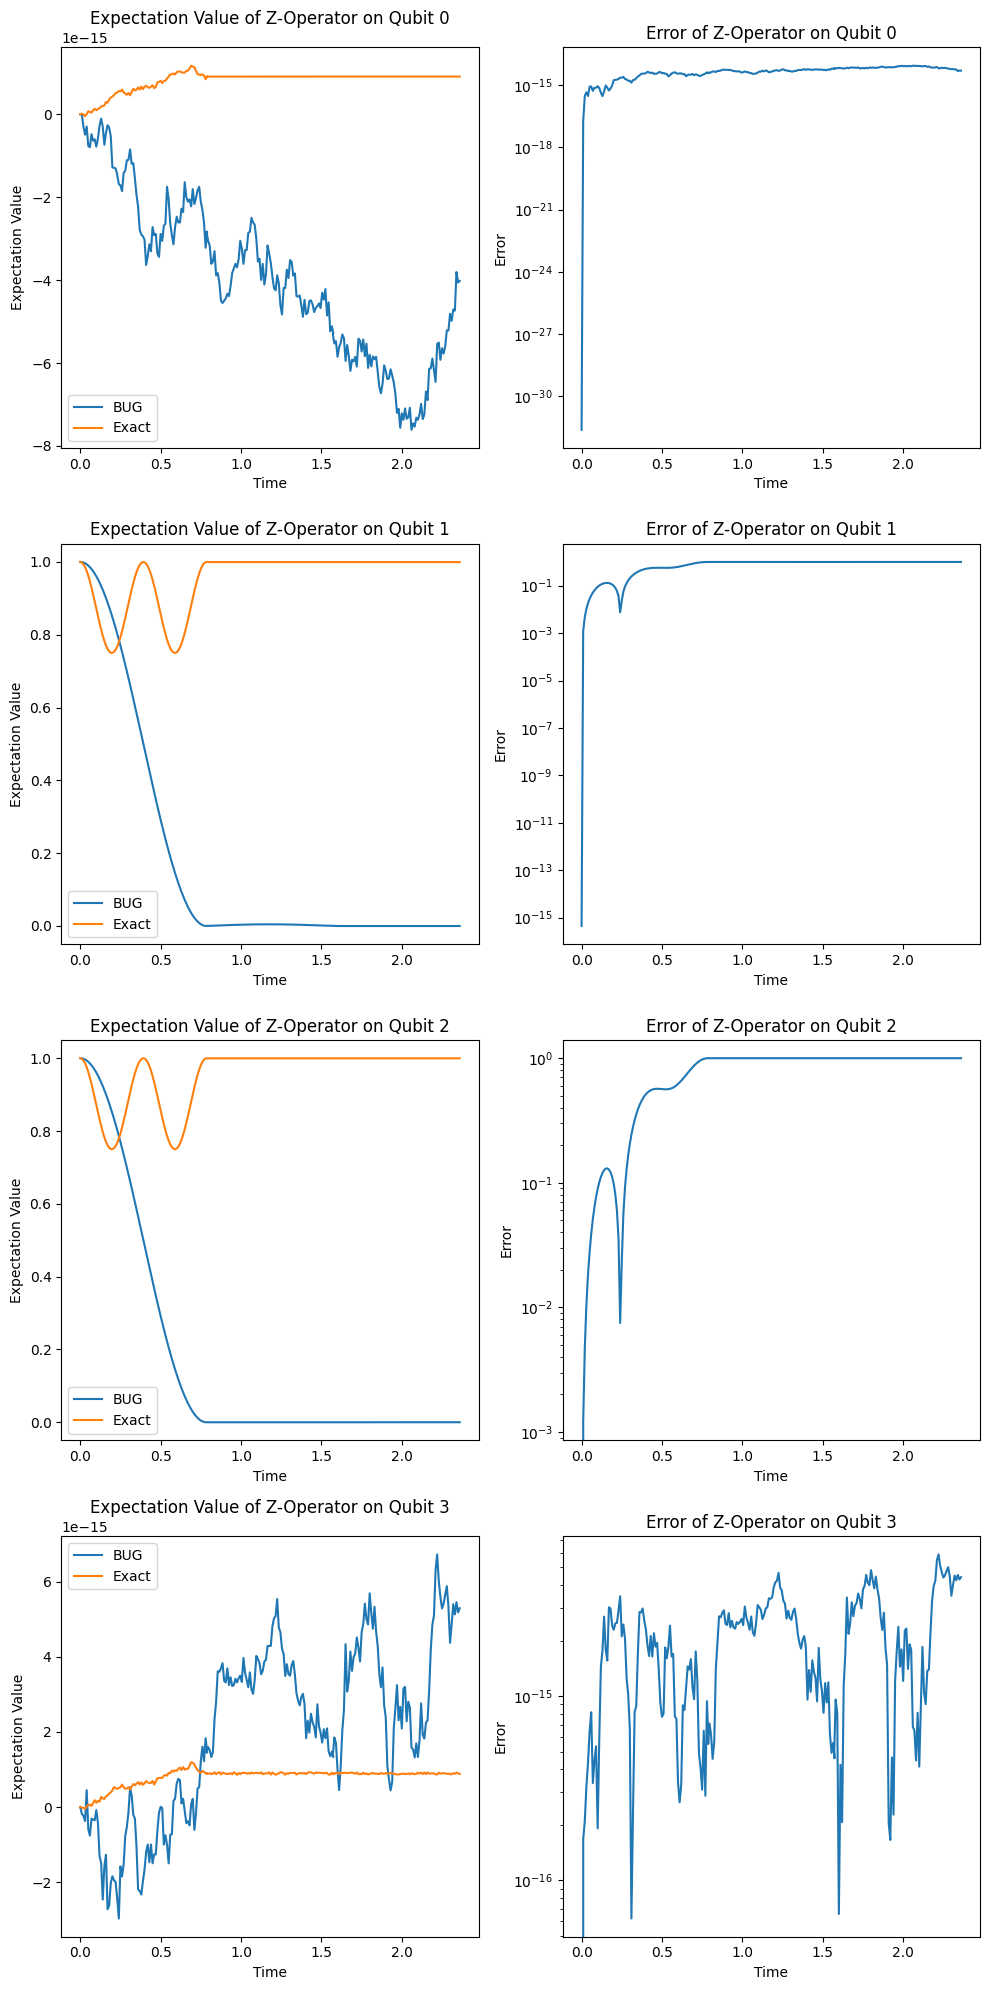

In [157]:
fig, axs = subplots(4, 2, figsize=(10, 20))

for i in range(num_sites):
    axs[i,0].plot(times, fq_results[i], label="BUG")
    axs[i,0].plot(times, fq_exact_results[i], label="Exact")
    axs[i,0].set_xlabel("Time")
    axs[i,0].set_ylabel("Expectation Value")
    axs[i,0].set_title(f"Expectation Value of Z-Operator on Qubit {i}")
    axs[i,0].legend()

    axs[i,1].semilogy(times, fq_errors[i])
    axs[i,1].set_xlabel("Time")
    axs[i,1].set_ylabel("Error")
    axs[i,1].set_title(f"Error of Z-Operator on Qubit {i}")

fig.tight_layout()
show()

In [158]:
def get_bug_bond_dim(bond_id: tuple[str,str]) -> ndarray:
    """
    Gets the bond dimension of a given bond.
    """
    bond_dim = "bond_dim"
    return append(fq_bug1.operator_result(bond_dim)[bond_id], append(fq_bug2.operator_result(bond_dim)[bond_id], fq_bug3.operator_result(bond_dim)[bond_id]))

In [159]:
bond_ids = [(qubit_ids[1], qubit_ids[0]), (qubit_ids[1], qubit_ids[2]), (qubit_ids[2], qubit_ids[3])]
bond_dims = {bond_id: get_bug_bond_dim(bond_id) for bond_id in bond_ids}

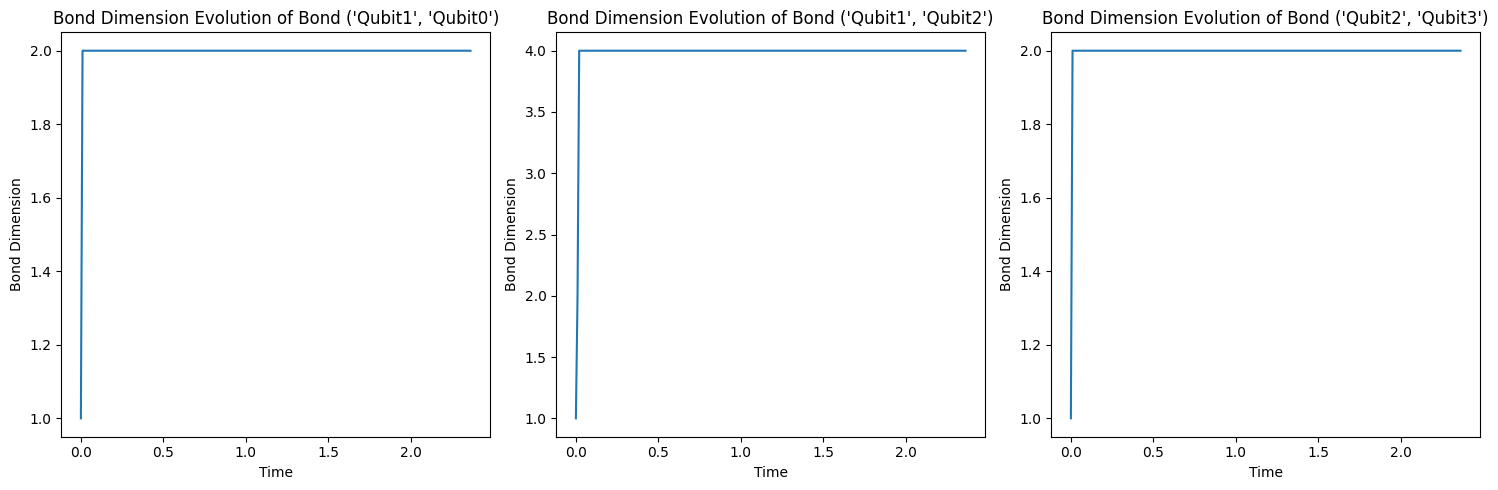

In [160]:
fig, axs = subplots(1,3, figsize=(15, 5))

for i, bond_id in enumerate(bond_ids):
    axs[i].plot(times, bond_dims[bond_id])
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Bond Dimension")
    axs[i].set_title(f"Bond Dimension Evolution of Bond {bond_id}")

fig.tight_layout()
show()